In this Notebook, we try to warp the PSF with LSST stack and GalSim

#### Table of contents

- [Some convenience functions](#Some-convenience-functions) (not of generic interest)
- [The cell where everything happens](#The-cell-where-everything-happens)
- [Reproducing the coaddPSF outside the LSST stack](#Reproducing-the-coaddPSF-outside-the-LSST-stack)
- [Warping PSF images with GalSim and LSST stack](#Warping-PSF-images-with-GalSim-and-LSST-stack)
- [Checking interpolation kernel with GalSim](#Checking-interpolation-kernel-with-GalSim)
- [Conclusions](#Conclusions)

In [1]:
## Do the imports and call the butler

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.meas.algorithms as measAlg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import galsim

butler = Butler("/datasets/hsc/repo/rerun/private/kannawad/RC2/w_2019_44_demo_lanczos5/")

Get the coadded PSF for one {tract,patch,filter} and focus on the PSF at the center of the coadd

In [2]:
## Define the interpolation kernel
x_interpolant = "lanczos5"

## Set some parameters
dataId = {'tract':9701, 'patch':'8,7', 'filter':'HSC-I'}
deepCoadd = butler.get("deepCoadd", dataId)

bbox = deepCoadd.getBBox()

## Pick the midpoint of the coadd to compute the PSF there
point = geom.Point2D(0.5*(bbox.x.min+bbox.x.max), 0.5*(bbox.y.min+bbox.y.max))
print("Midpoint: ", point)
assert bbox.contains(geom.Point2I(point))
print("Bounding box of the coadd: ", bbox)

coaddPsf = deepCoadd.getPsf()
coaddPsfIm = coaddPsf.computeKernelImage(geom.Point2D(point))
coaddWcs = deepCoadd.getWcs()
print("WCS of the coadd: ", coaddWcs)

Midpoint:  (33950, 30000)
Bounding box of the coadd:  (minimum=(31900, 27900), maximum=(35999, 32099))
WCS of the coadd:  FITS standard SkyWcs:
Sky Origin: (343.703704, +0.743802)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel


#### Some convenience functions

In [3]:
def FindMom(self):
    # returns the centroid and the 'standard deviation', sigma.
    im = self.view()
    im.setOrigin(0,0)
    origin = galsim.PositionD(x=self.origin.x,y=self.origin.y)
    #nrows, ncols = im.array.shape
    ncols, nrows = im.array.shape
    M0 = im.array.sum() # zero-th order moment
    # 1/M0 will be the uniform weight so that the sizes don't scale with the overall brightness of the image
    x = np.linspace(0,ncols-1,ncols)
    y = np.linspace(0,nrows-1,nrows)
    Sx = im.array.sum(1) # sum along y-axis
    Sy = im.array.sum(0) # sum along x-axis
    # Centroid
    x1 = np.dot(x,Sx)/M0
    y1 = np.dot(y,Sy)/M0
    M1 = galsim.PositionD(x=x1,y=y1)
    # Second moments
    Mxx = 1.0*np.dot((x-x1)**2,Sx)/M0
    Myy = 1.0*np.dot((y-y1)**2,Sy)/M0
    Mxy = 1.0*(x-x1).dot((im.array).dot(y-y1))/M0
    M2 = np.array([[Mxx,Mxy],[Mxy,Myy]])
    detM2 = Mxx*Myy - Mxy**2
    return M1+origin, M2, detM2**0.25

galsim.Image.FindMom = FindMom

def getTraceRadius(M2):
    Mxx = M2[0,0]
    Myy = M2[1,1]
    Mxy = M2[1,0]
    assert M2[1,0]==M2[0,1]
    
    return np.sqrt(0.5*(Mxx+Myy))

A set of convenience functions to convert an LSST WCS instance to an equivalent GalSim WCS instance

In [20]:
def rotate_jacobian(jac):
    ## Swap the axes for convention agreement 
    T = jac.copy()
    T[1,:] = jac[0,:]
    T[0,:] = jac[1,:] # -
    return T

def convertWCS_radec(lsstWCS, randomPoint):
    ## A callable function using the LSST WCS that maps image coordinates to world/sky coordinates 
    def radecfunc(x,y):
        imgPoint = geom.Point2D(x,y)
        skyPoint = lsstWCS.pixelToSky(imgPoint)
        return skyPoint.getRa().asRadians(), skyPoint.getDec().asRadians()

    galsimWCS = galsim.RaDecFunction(ra_func=radecfunc)
    return galsimWCS

def convertWCS_pixelscale(lsstWCS, randomPoint):
    galsimWCS = galsim.PixelScale(lsstWCS.getPixelScale().asArcseconds())
    return galsimWCS

def convertWCS_affine(lsstWCS, point):
    skyPoint = lsstWCS.pixelToSky(geom.Point2D(point))
    affine = afwGeom.makeTransform( lsstWCS.linearizePixelToSky(skyPoint, geom.arcseconds) )
    jac = affine.getJacobian(point) #* (3600.*180./np.pi)
    galjac = rotate_jacobian(jac)
    galsimWCS = galsim.AffineTransform(galjac[0,0], galjac[0,1], galjac[1,0], galjac[1,1])
    return galsimWCS
    
## Define an alias to whichever function you want to choose
convertWCS = convertWCS_affine

#### The cell where everything happens

We do quite a few things in the cell below.
- Find the corresponding point in the individual calexps (that contribute to that point in the coadd)
- Get the PSF for the calexps at that point
- Implement the warp using LSST stack tools (but outside the stack) to reproduce the coadded PSF
- Implement the same using GalSim

In [16]:
## Generate the warpedPSF explicitly, and compare with that from the LSST stack
%time

## Declare various lists to store the various warp quantities
component_list = [ ]
xyTransform_list = [ ]
orig_psf_image_list = [ ]
orig_psf_image_copy_list = [ ]
galsim_warped_psf_image_list = [ ]
galsim_moments =  [ ]
moments = [ ]
psf_image_list = [ ]
psf_image_copy_list = [ ]
psf_weight_list = [ ]

## Define the warping control explicitly
wc = afwMath.WarpingControl(warpingKernelName=x_interpolant, interpLength=10)

for i in range(coaddPsf.getComponentCount()):
    ## Get the point in the calexp corresponding to the chosen point on the codd, which is its center
    calexpPoint = deepCoadd.getPsf().getWcs(i).skyToPixel(coaddWcs.pixelToSky(geom.Point2D(point)))
    if deepCoadd.getPsf().getValidPolygon(i).contains(calexpPoint):
        component_list.append(i)
        xyTransform = afwGeom.makeWcsPairTransform(coaddPsf.getWcs(i), coaddWcs)
        xyTransform_list.append(xyTransform)
        orig_psf = coaddPsf.getPsf(i)
        orig_psf_image = orig_psf.computeKernelImage(xyTransform.applyInverse(point))
        orig_psf_image_copy = afwImage.ImageD(array=orig_psf_image.array, deep=True, xy0=geom.Point2I(0,0))
        orig_psf_image_list.append( orig_psf_image )

        ## Modify the pixel values of orig_psf_image to see what the warping functions do
        
        ## Set it to True to make the PSF image a Gaussian one
        if False:
            gaussian_image = galsim.Image(orig_psf_image.array)
            gaussian_image = galsim.Gaussian(sigma=3.2).drawImage(image=gaussian_image, scale=1.0)
            orig_psf_image.array = gaussian_image.array
            
        ## Set it to True to make the PSF image a point source
        if:
            orig_psf_image.array *= 0.
            orig_psf_image.array[20,20] = 1.
        
        ## Implement the warping using LSST stack tools
        warped_psf = measAlg.WarpedPsf(orig_psf, xyTransform, kernelName=x_interpolant)
        psf_image = warped_psf.computeKernelImage(point)
        psf_image_list.append( psf_image )
 
        ## Save the weights to combine them to a coadd
        psf_weight_list.append( coaddPsf.getWeight(i) )
        
        psf_image_copy = afwImage.ImageD(array=np.zeros_like(psf_image.array), deep=True, xy0=geom.Point2I(0,0))
        afwMath.warpImage(destImage=psf_image_copy, srcImage=orig_psf_image, srcToDest=xyTransform, control=wc, padValue=0.0)
        psf_image_copy_list.append(psf_image_copy)
        
        ## Create a galsim.Image instance of the PSf image
        galsimWCS = convertWCS(coaddPsf.getWcs(i), calexpPoint)
        interp_image = galsim.InterpolatedImage(galsim.Image(orig_psf_image.array, wcs=galsimWCS), x_interpolant=x_interpolant)
        ## Shift the image if there are differences in center pixel convenetions
        interp_image = interp_image.shift(dx=0*0.5*0.168,dy=0*0.5*0.168)
        
        ## Implement the warping in GalSim
        jac = xyTransform.getJacobian(calexpPoint)
        T = jac ## T is the transformation matrix
        print("Trans T = ", T)
        T = rotate_jacobian(jac) ## T is the transformation matrix
        
        galsim_warped_psf = interp_image.transform(dudx=T[0,0],dvdy=T[1,1],dudy=T[0,1],dvdx=T[1,0])
        galsim_warped_psf_image = galsim_warped_psf.drawImage(image=galsim.Image(ncol=psf_image.array.shape[1],nrow=psf_image.array.shape[0],init_value=0.), method='sb', offset=galsim.PositionD(-0.,-0.), wcs=convertWCS(coaddWcs,point))
        galsim_warped_psf_image_list.append(galsim_warped_psf_image)
        
        ## Make size measurements
 #       galsim_moments.append( galsim_warped_psf_image.FindAdaptiveMom() )
 #       moments.append( warped_psf.computeShape(point) )
        
        ## Some consistency checks
        assert galsim_warped_psf_image.array.shape[0]==psf_image.array.shape[0]
        assert galsim_warped_psf_image.array.shape[1]==psf_image.array.shape[1]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11.2 µs
Trans T =  [[ 0.01646739  0.97657136]
 [-0.94624606 -0.01622149]]
Trans T =  [[-0.02496888 -0.96238701]
 [ 0.94606889  0.0247067 ]]
Trans T =  [[-0.01669348  0.95780331]
 [-0.97605498  0.0175997 ]]
Trans T =  [[-8.14401463e-04 -1.00110070e+00]
 [ 1.00348873e+00 -1.31966224e-03]]
Trans T =  [[-0.0173617   0.9741043 ]
 [-0.96097477  0.01853751]]
Trans T =  [[ 1.13747519e-03  9.29699466e-01]
 [-9.80906183e-01 -5.54905362e-04]]


Perform the coaddition, which is simply a linear combination of the warps. For reasons unknown to me, not all PSF images are 41x41 pixels as they should have been(?). So combining them in a messy way.

In [17]:
## Using a hacky+messy way to combine the warps so that the image sizes are the same
newCoaddPsfIm = np.zeros_like(psf_image_list[3].array)
newCoaddPsfIm_copy = np.zeros_like(newCoaddPsfIm)
for i in range(len(psf_image_list)):
    psfim = psf_image_list[i]
    if psfim.array.shape[1] == 39: ## HACK
        newCoaddPsfIm[1:-1,2:-2] += psf_weight_list[i]*psf_image_list[i].array/psf_image_list[i].array.sum()
        newCoaddPsfIm_copy[1:-1,2:-2] += psf_weight_list[i]*psf_image_copy_list[i].array/psf_image_copy_list[i].array.sum()
    elif psfim.array.shape[1] == 41:
        newCoaddPsfIm[1:-1,1:-1] += psf_weight_list[i]*psf_image_list[i].array/psf_image_list[i].array.sum()
        newCoaddPsfIm_copy[1:-1,1:-1] += psf_weight_list[i]*psf_image_copy_list[i].array/psf_image_copy_list[i].array.sum()
    else:
        newCoaddPsfIm += psf_weight_list[i]*psf_image_list[i].array/psf_image_list[i].array.sum()
        newCoaddPsfIm_copy += psf_weight_list[i]*psf_image_copy_list[i].array/psf_image_copy_list[i].array.sum()
newCoaddPsfIm /= np.sum(psf_weight_list)
newCoaddPsfIm_copy /= np.sum(psf_weight_list)

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


#### Reproducing the coaddPSF outside the LSST stack

We show that we recover the coadded PSF from the individual PSFs processed with the LSST stack tools

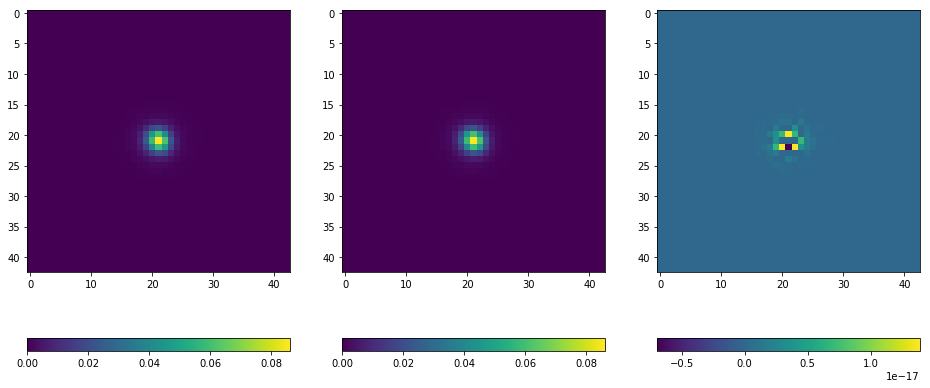

In [18]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(16,8)
_im = ax[0].imshow(newCoaddPsfIm)
fig.colorbar(_im,ax=ax[0],orientation='horizontal')
_im = ax[1].imshow(coaddPsfIm.array)
fig.colorbar(_im,ax=ax[1],orientation='horizontal')
diff_im = newCoaddPsfIm - coaddPsfIm.array
_im = ax[2].imshow(diff_im)
fig.colorbar(_im,ax=ax[2],orientation='horizontal')

## Warping PSF images with GalSim and LSST stack

Now that we are confident of our implementation outside of our stack, we compare the PSFs from GalSim implementation with that of LSST implementation

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Ratio of max:  35.55415399937166
Ratio of max:  32.76044464111326
Ratios of max to sum: 0.07614802 0.0701645994161541
GalSim trace radius =  2.36289860229258
LSST trace radius =  2.4618928827910276


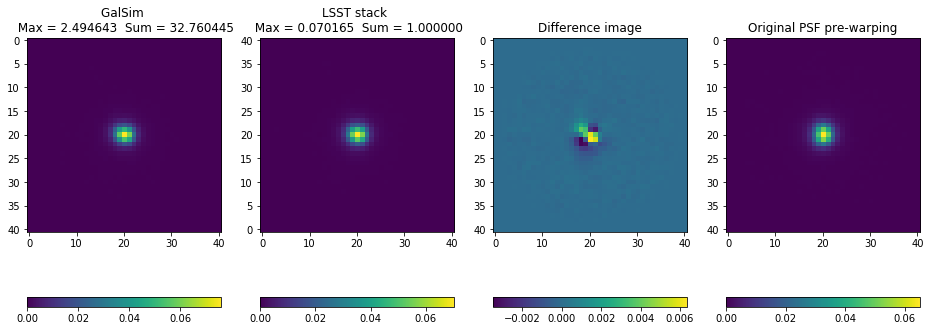

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


Ratio of max:  35.56560760706293
Ratio of max:  32.22973632812493
Ratios of max to sum: 0.10394859 0.09419874777963791
GalSim trace radius =  1.859486835220834
LSST trace radius =  1.961478284915363


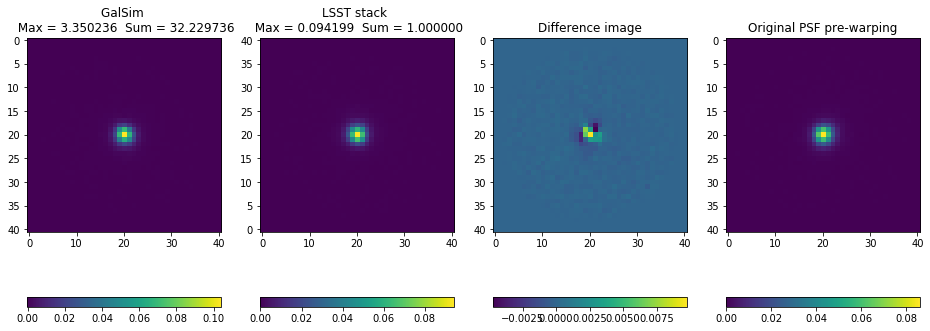

Ratio of max:  35.566573134526905
Ratio of max:  33.18258666992177
Ratios of max to sum: 0.08394656 0.07831972379381966
GalSim trace radius =  2.195402008684655
LSST trace radius =  2.2739456831937974


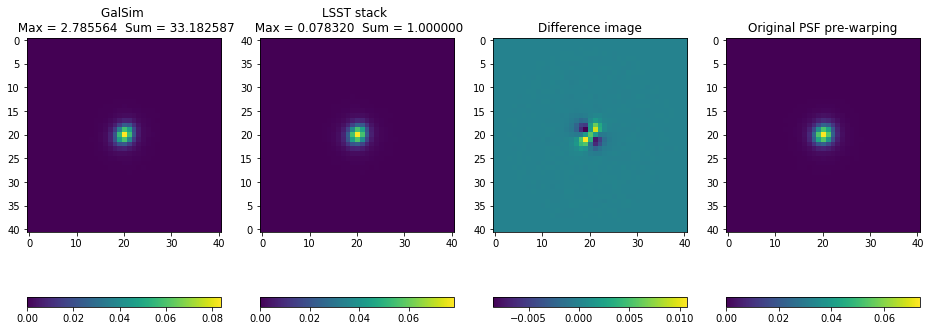

Ratio of max:  35.428929808320675
Ratio of max:  35.57696914672851
Ratios of max to sum: 0.09177985 0.0921633543989775
GalSim trace radius =  2.332353072067279
LSST trace radius =  2.328572215965744


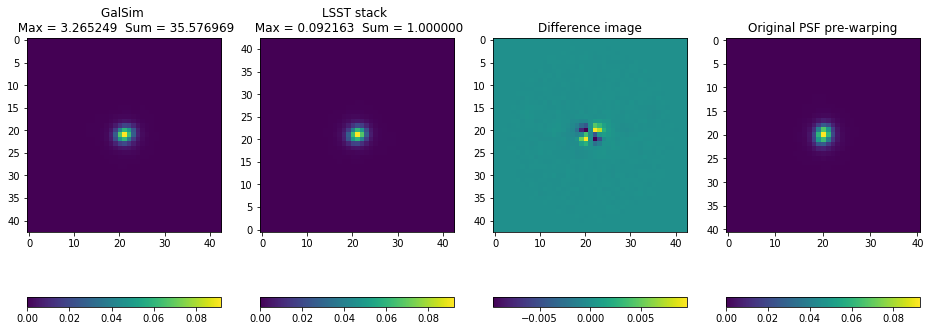

Ratio of max:  35.57021318520646
Ratio of max:  33.23503494262688
Ratios of max to sum: 0.08411732 0.07859503464236076
GalSim trace radius =  2.171193401988471
LSST trace radius =  2.247308016550334


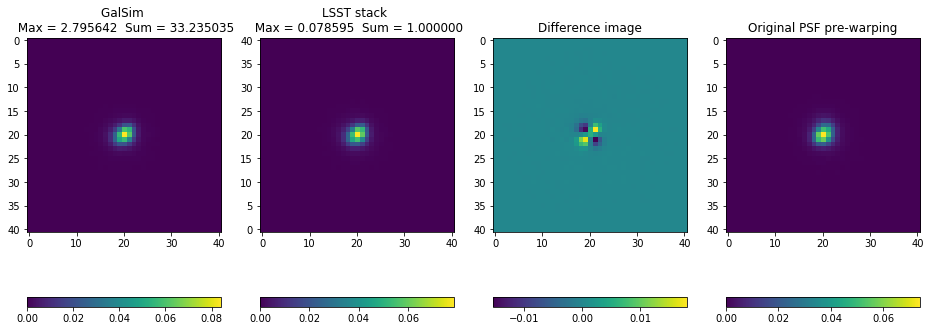

Ratio of max:  35.526359915717286
Ratio of max:  32.304336547851484
Ratios of max to sum: 0.112202935 0.1020268169059853
GalSim trace radius =  1.9809429429761398
LSST trace radius =  2.0761964992328306


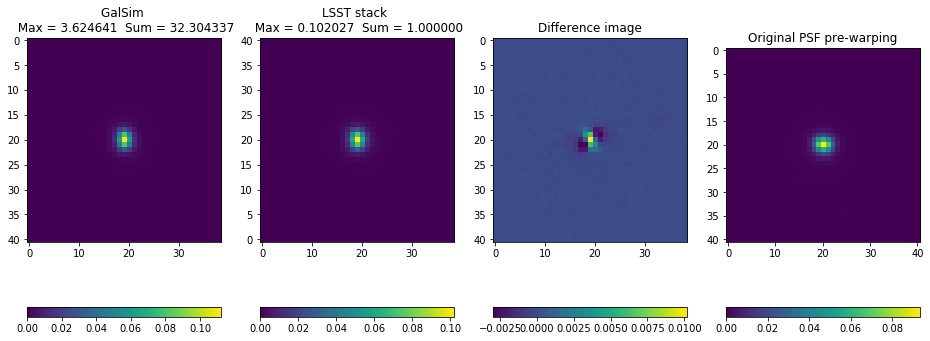

In [19]:
#fig, ax = plt.subplots(3,len(galsim_warped_psf_image_list))
#fig.set_size_inches(100,40)
for psf_id in range(len(galsim_warped_psf_image_list)):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(16,8)
    psf_im = galsim_warped_psf_image_list[psf_id]
    norm_im1 = galsim_warped_psf_image_list[psf_id].array/galsim_warped_psf_image_list[psf_id].array.sum()
    
    ratio_im = psf_im.array/psf_image_list[psf_id].array
    thres=3; ratio_im[ratio_im>thres] = thres; ratio_im[ratio_im<-thres] = -thres;
    _im1 = ax[0].imshow(norm_im1)
    ax[0].set_title("GalSim \n Max = %6f  Sum = %4f" % (psf_im.array.max(), psf_im.array.sum()))
    _cbar1 = fig.colorbar(_im1, ax=ax[0],orientation='horizontal')
    
    norm_im2 = psf_image_list[psf_id].array/psf_image_list[psf_id].array.sum()
    _im2 = ax[1].imshow(norm_im2, origin='lower')
    ax[1].set_title("LSST stack \n Max = %6f  Sum = %4f" % (psf_image_list[psf_id].array.max(), psf_image_list[psf_id].array.sum()))
    _cbar2 = fig.colorbar(_im2, ax=ax[1],orientation='horizontal')
    
    diff_im = norm_im1 - norm_im2
    _im3 = ax[2].imshow(diff_im)
    ax[2].set_title("Difference image")
    #_im3 = ax[2,psf_id].imshow(psf_image_copy_list[psf_id].array/psf_image_copy_list[psf_id].array.sum())
    _cbar3 = fig.colorbar(_im3, ax=ax[2],orientation='horizontal')
    
    _im4 = ax[3].imshow(orig_psf_image_list[psf_id].array)
    ax[3].set_title("Original PSF pre-warping")
    _cbar4 = fig.colorbar(_im4, ax=ax[3],orientation='horizontal')


    #ax[1].set_title("Max = "+str(psf_image_list[psf_id].array.max())+"  Sum = "+str(psf_image_list[psf_id].array.sum()))
    
    print("Ratio of max: ", psf_im.array.max()/psf_image_list[psf_id].array.max())
    print("Ratio of max: ", psf_im.array.sum()/psf_image_list[psf_id].array.sum())
    print("Ratios of max to sum:", psf_im.array.max()/psf_im.array.sum(), psf_image_list[psf_id].array.max()/psf_image_list[psf_id].array.sum())
    
    M1, M2, determinantRadius = galsim_warped_psf_image_list[psf_id].FindMom()
    traceRadius = getTraceRadius(M2)
    print("GalSim trace radius = ", traceRadius)
    
    M1, M2, determinantRadius = galsim.Image(psf_image_list[psf_id].array).FindMom()
    traceRadius = getTraceRadius(M2)
    print("LSST trace radius = ", traceRadius)
    
    
    plt.show()

- Warning: The disagreement between LSST stack output and GalSim output isn't alarming by itself, as I had thought originally. I have come to realise that the warping operations are designed to achieve different things, hence this comparison isn't all that useful.

- However, it is interesting to note that the trace radius from GalSim warped images are almost always larger. 

- The dipole pattern in the difference images is somewhat distrubing. It seems to suggest the GalSim warped PSFs are more extended than the LSST stack warped ones.

## Checking interpolation kernel with GalSim

The differences between GalSim and LSST stack PSF images are not due to difference in interpolation kernels themselves. See [this notebook](check_interpolation.ipynb) where I create a high resolution image from a lower resolution image using GalSim and LSST stack kernels, and they agree extremely well.

# Conclusions

## a.k.a. explanation hithertho unexplored

- The PSF model and the calexps are essentially warped by the same function. Any differences between them could not possibly occur due to a bug in the warping functionality.

    * There is a minor difference between how PSFs and calexps are warped. An affine transformation is computed at the location of the star to warp the PSF but the calexp is warped with local affine transformations calculated at interpLength=10 pixels. This is unlikely to cause the difference we see.


- I am beginning to think this is a discrepancy with the measurement rather than image manipulation. My hypothesis is that the CModel fit, from which the trace radius is computed, is biased due to correlated noise in the warps and coadds. The correlation depends on the interpolation kernel chosen, which is what I bet we are witnessing.

#### Testing the WCS conversion

In [9]:
galsimWCS = convertWCS(coaddWcs, point)

skyPoint = coaddWcs.pixelToSky(geom.Point2D(point))
lsstWCS = afwGeom.makeTransform( coaddWcs.linearizePixelToSky(skyPoint, geom.arcseconds) )

print("GalSim WCS = ", galsimWCS)
print("LSST WCS = ", lsstWCS.getJacobian(point))

GalSim WCS =  galsim.AffineTransform(4.966028586781432e-05, -0.16796977624336407, -0.16796362064276835, -2.8332780182318732e-05, origin=galsim.PositionD(x=0.0, y=0.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
LSST WCS =  [[-1.67963621e-01 -2.83327802e-05]
 [-4.96602859e-05  1.67969776e-01]]


#### Q & A for self

- This is hidden, but you could pass the kernelName to WarpedPsf !
- How is the average position of the WarpedPsf always pairs of perfect integers when the orig_psf has fractional average positions

    (Is this) Because an integer position for the coaddPsf is calculated first, and the average position of the calexp Psfs are found from the inverse
    
- Why do the average positions of the WarpedPsf vary so much?
    
- What does the line containing ndarray::asEigenmatrix do exactly?

    Likely, normalizes the pixel values in the PSF image to sum to unity
    